# HR-аналитика компании «Работа с заботой» 

HR-аналитики компании «Работа с заботой» помогают бизнесу оптимизировать управление персоналом: бизнес предоставляет данные, а аналитики предлагают, как избежать финансовых потерь и оттока сотрудников. В этом HR-аналитикам пригодится машинное обучение, с помощью которого получится быстрее и точнее отвечать на вопросы бизнеса. Компания предоставила данные с характеристиками сотрудников компании.

**Цель проекта:** спрогнозировать отток сотрудников. 

**Задачи:**

1. Построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

2. Построить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.



**Описание данных: Заказчик предоставил данные с признаками:**- 


- id — уникальный идентификатор сотрудника;
- dept — отдел, в котором работает сотрудник;
- level — уровень занимаемой должности;
- workload — уровень загруженности сотрудника;
- employment_years — длительность работы в компании (в годах);
- last_year_promo — показывает, было ли повышение за последний год;
- last_year_violations — показывает, нарушал ли сотрудник трудовой договор за последний год;
- supervisor_evaluation — оценка качества работы сотрудника, которую дал руководитель;
- salary — ежемесячная зарплата сотрудника;
- job_satisfaction_rate — уровень удовлетворённости сотрудника работой в компании, целевой признак.
- quit - увольнение сотрудника из компании (используется во второй задаче)



**План:**

1. **Задача 1** -  предсказать уровень удовлетворённости сотрудника:
    - Загрузка данных
    - Предобработка данных
    - Исследовательский анализ данных
    - Подготовка данных
    - Обучение моделей
    - Промежуточный вывод
    
    
2. **Задача 2** - предсказать то, что сотрудник уволится из компании:
    - Загрузка данных
    - Предобработка данных
    - Исследовательский анализ данных
    - Добавление нового входного признака
    - Подготовка данных
    - Обучение моделей
    - Промежуточный вывод
    
    
3. **Общий вывод**

## Задача 1: предсказание уровня удовлетворённости сотрудника

### Загрузка данных

In [1]:
!pip install scikit-learn==1.1.0 --quiet --disable-pip-version-check
!pip install matplotlib==3.5.1 --quiet --disable-pip-version-check
!pip install shap --quiet --disable-pip-version-check
!pip install phik --quiet --disable-pip-version-check

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler,
    LabelEncoder,
    RobustScaler
)
from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_auc_score, make_scorer

from phik.report import plot_correlation_matrix
from phik import phik_matrix

import shap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
#from scipy import stats as st

# import warnings filter
from warnings import simplefilter

In [3]:
try:
    train_df = pd.read_csv('train_job_satisfaction_rate.csv') 
    X_test = pd.read_csv('test_features.csv')
    y_test = pd.read_csv('test_target_job_satisfaction_rate.csv')
except:
    train_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv') 
    X_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv')
    y_test = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv')

In [4]:
df_list = [train_df, X_test, y_test]

In [5]:
def df_print(list):
    for df in list:
        display(df.sample(10))

In [6]:
df_print(df_list)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
3970,335472,purchasing,middle,high,7,no,no,5,51600,0.62
2009,496482,technology,junior,low,1,no,no,3,22800,0.31
2562,230341,hr,middle,high,3,no,no,5,51600,0.49
3546,189131,technology,middle,low,7,no,yes,3,21600,0.11
2036,248320,marketing,junior,medium,1,no,no,4,27600,0.70
1621,591539,sales,junior,high,1,no,yes,2,32400,0.14
2229,364917,hr,junior,medium,2,no,no,4,22800,0.65
3615,517610,sales,junior,low,1,no,no,3,14400,0.23
3850,175613,sales,middle,medium,6,no,no,4,38400,0.82
3833,914154,sales,junior,medium,3,no,no,3,20400,0.27


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
171,315687,sales,middle,low,4,no,no,3,18000
634,773945,purchasing,middle,high,4,no,no,5,61200
1097,310149,sales,junior,medium,1,no,no,3,27600
1128,537807,technology,middle,high,6,no,no,4,68400
1489,668018,sales,junior,medium,3,no,no,2,27600
623,406667,sales,middle,medium,10,no,no,3,32400
1817,614444,sales,junior,low,2,no,no,4,12000
1324,207456,hr,junior,medium,1,no,yes,4,30000
1506,990011,marketing,middle,low,6,yes,no,4,31200
1154,547525,technology,middle,high,7,no,no,4,62400


,id,job_satisfaction_rate
867,390119,0.76
237,640465,0.71
534,331127,0.50
915,105901,0.75
1790,349366,0.67
1376,540028,0.43
1920,408188,0.41
450,914306,0.82
89,381809,0.19
1312,605355,0.65


In [7]:
def df_info(list):
    for df in list:
        df.info()
        print('\n')

In [8]:
df_info(df_list)

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 4000 entries, 0 to 3999
,Data columns (total 10 columns):
, #   Column                 Non-Null Count  Dtype  
,---  ------                 --------------  -----  
, 0   id                     4000 non-null   int64  
, 1   dept                   3994 non-null   object 
, 2   level                  3996 non-null   object 
, 3   workload               4000 non-null   object 
, 4   employment_years       4000 non-null   int64  
, 5   last_year_promo        4000 non-null   object 
, 6   last_year_violations   4000 non-null   object 
, 7   supervisor_evaluation  4000 non-null   int64  
, 8   salary                 4000 non-null   int64  
, 9   job_satisfaction_rate  4000 non-null   float64
,dtypes: float64(1), int64(4), object(5)
,memory usage: 312.6+ KB
,
,
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 2000 entries, 0 to 1999
,Data columns (total 9 columns):
, #   Column                 Non-Null Count  Dtype 
,---  ------            

#### Вывод

1. Данные в таблицах соответствуют описанию.
2. Названия колонок в общепринятом стиле
3. Верные типы данных
4. На данном этапе выявлены пропуски в train_job_satisfaction_rate, test_features

### Предобработка данных

In [9]:
for df in df_list:
    df.set_index('id', inplace=True)

In [10]:
df_list_name = ['train_df', 'X_test', 'y_test']

In [11]:
# функция для поиска опечаток
def misprint_df(list_df, list_name):
    k =0
    for df in list_df:
        for col in list(df):
            if df[col].dtype == 'object':
                df[col] = df[col].str.lower()
                print(list_name[k], df[col].unique().tolist())
        k += 1

In [12]:
# найдем опечатки
misprint_df(df_list, df_list_name)

train_df ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]
,train_df ['junior', 'middle', 'sinior', nan]
,train_df ['medium', 'high', 'low']
,train_df ['no', 'yes']
,train_df ['no', 'yes']
,X_test ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' ']
,X_test ['junior', 'middle', 'sinior', nan]
,X_test ['medium', 'low', 'high', ' ']
,X_test ['no', 'yes']
,X_test ['no', 'yes']


In [13]:
# приведем пропуски к np.nan
X_test['dept'] = X_test['dept'].replace(' ', np.nan,  regex=True)
X_test['workload'] = X_test['workload'].replace(' ', np.nan,  regex=True)

In [14]:
# исправим ошибку
train_df['level'] = train_df['level'].replace('sinior', 'senior', regex=True) 
X_test['level'] = X_test['level'].replace('sinior', 'senior', regex=True)

In [15]:
misprint_df(df_list, df_list_name)

train_df ['sales', 'hr', 'technology', 'purchasing', 'marketing', nan]
,train_df ['junior', 'middle', 'senior', nan]
,train_df ['medium', 'high', 'low']
,train_df ['no', 'yes']
,train_df ['no', 'yes']
,X_test ['marketing', 'hr', 'sales', 'purchasing', 'technology', nan]
,X_test ['junior', 'middle', 'senior', nan]
,X_test ['medium', 'low', 'high', nan]
,X_test ['no', 'yes']
,X_test ['no', 'yes']


In [16]:
# функция для поиска дубликатов и пропусков
def skip_and_dup(list, list_name):
    k = 0

    for df in list:
        print('-' * 30)
        print(f'\t{list_name[k]}\n\nдубликаты: {df.duplicated().sum()}\n\nпропуски:\n{df.isna().sum().sort_values()}')
        k += 1

In [17]:
skip_and_dup(df_list, df_list_name)

------------------------------
,	train_df
,
,дубликаты: 245
,
,пропуски:
,workload                 0
,employment_years         0
,last_year_promo          0
,last_year_violations     0
,supervisor_evaluation    0
,salary                   0
,job_satisfaction_rate    0
,level                    4
,dept                     6
,dtype: int64
,------------------------------
,	X_test
,
,дубликаты: 557
,
,пропуски:
,employment_years         0
,last_year_promo          0
,last_year_violations     0
,supervisor_evaluation    0
,salary                   0
,level                    1
,workload                 1
,dept                     3
,dtype: int64
,------------------------------
,	y_test
,
,дубликаты: 1902
,
,пропуски:
,job_satisfaction_rate    0
,dtype: int64


In [18]:
# удалим дубликаты
train_df = train_df.drop_duplicates()
train_df.shape

(3755, 9)

#### Вывод

- Были обнаружены пропуски, которые заданы по разному. Привели к np.nan, обработка будет в пайплайне в следующих шагах.


- Дубликаты обнаружены и удалены в тренировочной выборке. Дубликаты в тестовых выборках удалять не будем, на качество обучения модели они не повлияют.


- Была исправлена опечатка в слове "senior".


- Неявных дубликатов не выявлено.

### Исследовательский анализ данных

In [19]:
dict_list = {
    'workload': ' уровень загруженности сотрудника',
    'employment_years': 'длительность работы в компании (в годах)',
    'last_year_promo': 'было ли повышение за последний год',
    'last_year_violations': 'нарушал ли сотрудник трудовой договор за последний год',
    'supervisor_evaluation': 'оценка качества работы сотрудника от рук.',
    'salary': 'ежемесячная зарплата сотрудника',
    'job_satisfaction_rate': 'уровень удовлетворённости сотрудника работой',
    'level': ' уровень занимаемой должности',
    'dept': 'отдел'
}

In [20]:
# функция для построения гистрограммы и боксплота
def graph_num_df(df):
    col_list = []
    col_key_list = []
    
    numeric_cols = df.select_dtypes(include='number').columns
    
    for col in numeric_cols:
        col_key_list.append(dict_list[col])
        col_list.append(col)


    for k in col_list:
        i = col_key_list[col_list.index(k)]
        
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
        fig.suptitle(i, fontsize=18)  
        
        sns.histplot(data=df, x=k, ax=axes[0], bins=40, kde=True)
        axes[0].axvline(x=df[k].describe().T["50%"], color='g')
        axes[0].set_title('Гистограмма распределения', fontsize=16)
        axes[0].set_xlabel(i, fontsize=16)
        axes[0].set_ylabel('Плотность распределения', fontsize=16)
        
       
        sns.boxplot(data=df, x=k, ax=axes[1])
        axes[1].set_title('Разброс значений признаков', fontsize=16)
        axes[1].set_ylabel('')
        axes[1].set_xlabel(i, fontsize=16)
        
        plt.show()

In [21]:
# функция для построения круговой диаграммы для категориальных признаков 
def graph_cat_df(df):
    col_list = []
    col_key_list = []
    
    categ_cols = df.select_dtypes(include='object').columns
    
    for col in categ_cols:
        col_key_list.append(dict_list[col])
        col_list.append(col)
        
    count = len(categ_cols)   
                 
    if count > 1:
        j = 1
        while j != (count + 1):
            plt.figure(figsize=(20, 20))
            
            for k in col_list:
                plt.subplot(5, 2, j)
                
                i = col_key_list[col_list.index(k)]
   
                df[k].value_counts().plot(
                    kind='pie',
                    subplots=True,
                    autopct='%.1f%%',
                    legend=False,
                    fontsize=16
                )
                plt.axis('off')
                plt.title(i, fontsize=18)
                plt.subplots_adjust(top=0.9)
                plt.tight_layout()
                j += 1
        plt.show()
    else:
        for k in col_list:
            i = col_key_list[col_list.index(k)]
            df[k].value_counts().plot(kind='pie', subplots=True, autopct='%.1f%%', legend=False)
            plt.axis('off')
            plt.title(i, fontsize=18)
            plt.show()

 train_df


,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,3.476500,33926.700000,0.533995
std,2.542513,1.008812,14900.703838,0.225327
min,1.000000,1.000000,12000.000000,0.030000
25%,2.000000,3.000000,22800.000000,0.360000
50%,3.000000,4.000000,30000.000000,0.560000
75%,6.000000,4.000000,43200.000000,0.710000
max,10.000000,5.000000,98400.000000,1.000000


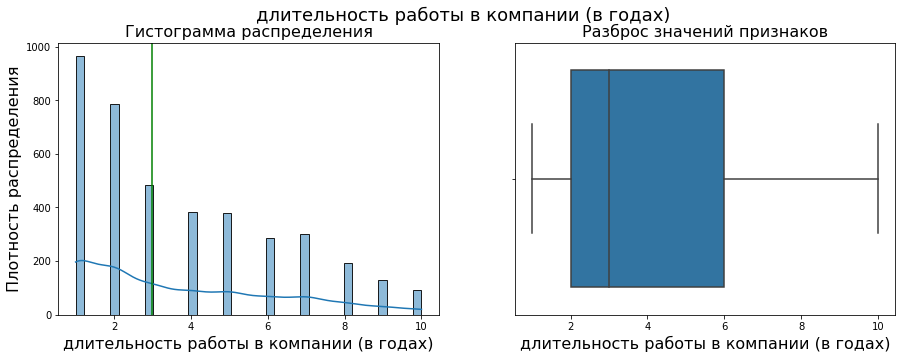

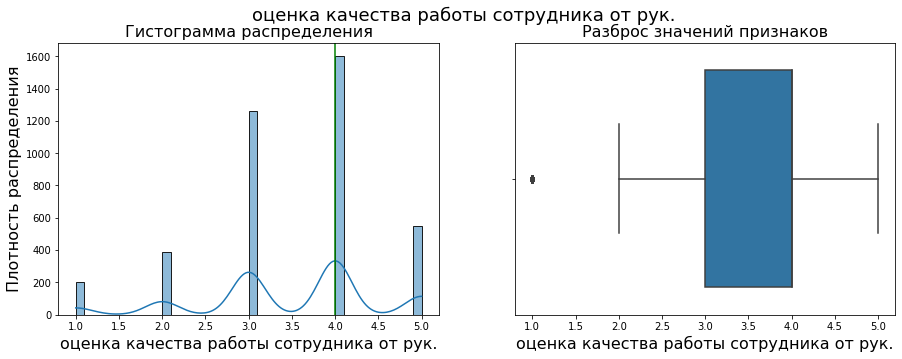

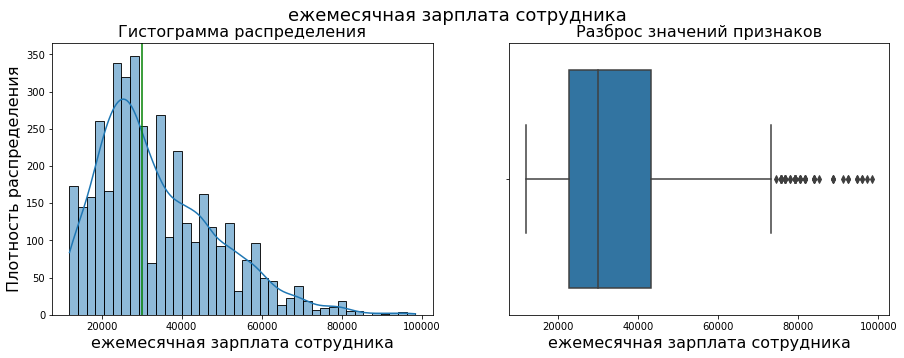

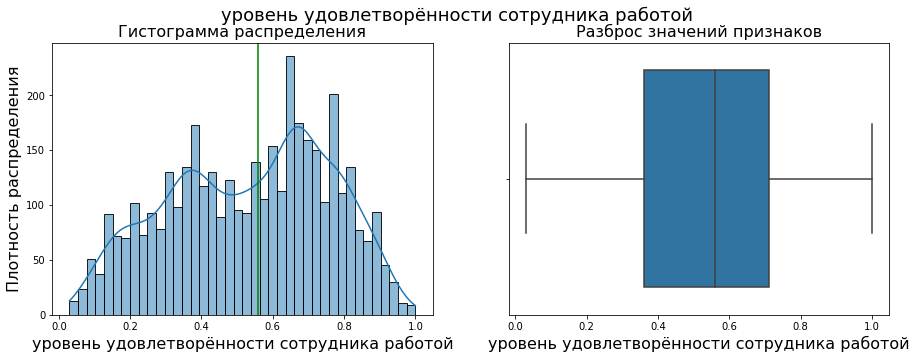

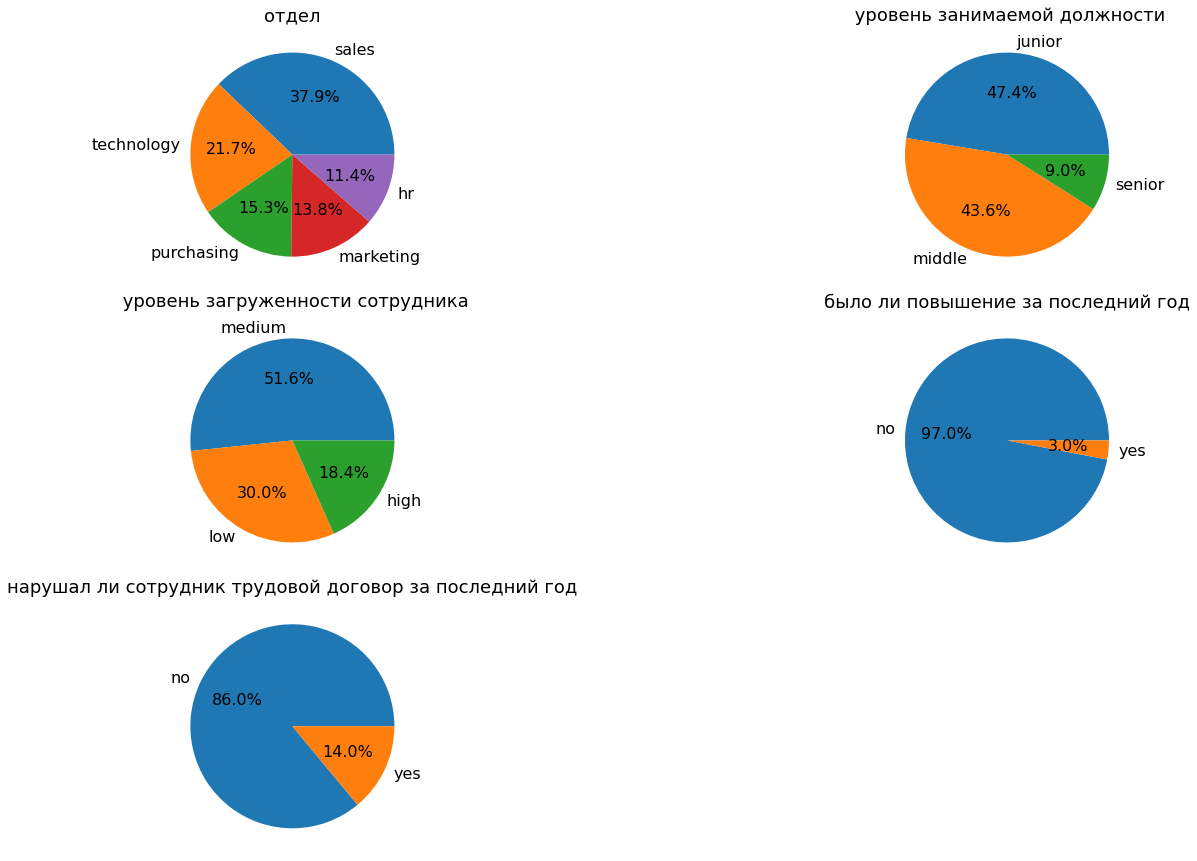

------------------------------------------------------------------------------------------------------------------------
, X_test


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


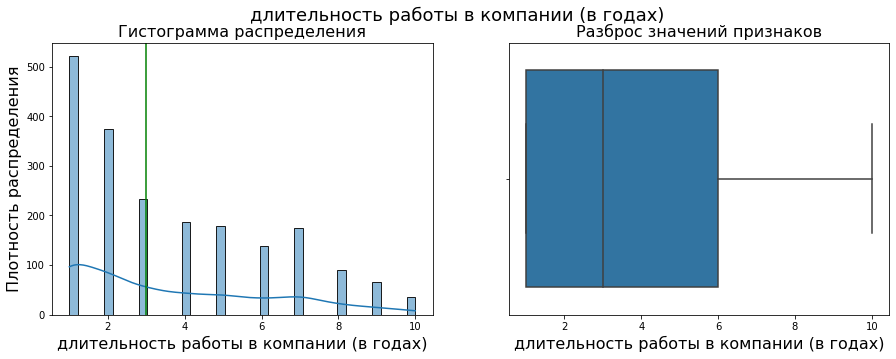

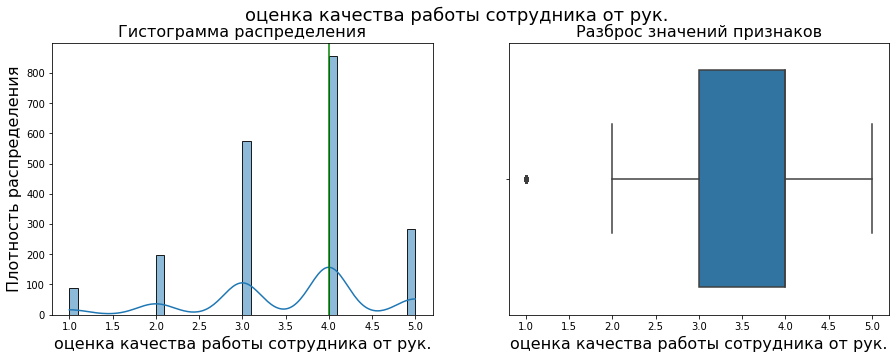

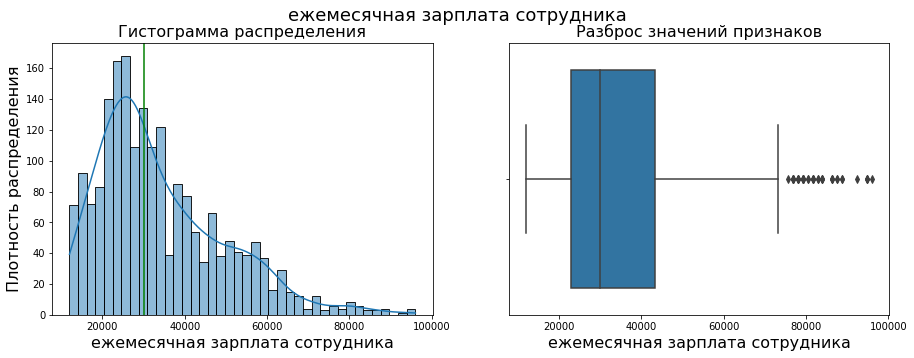

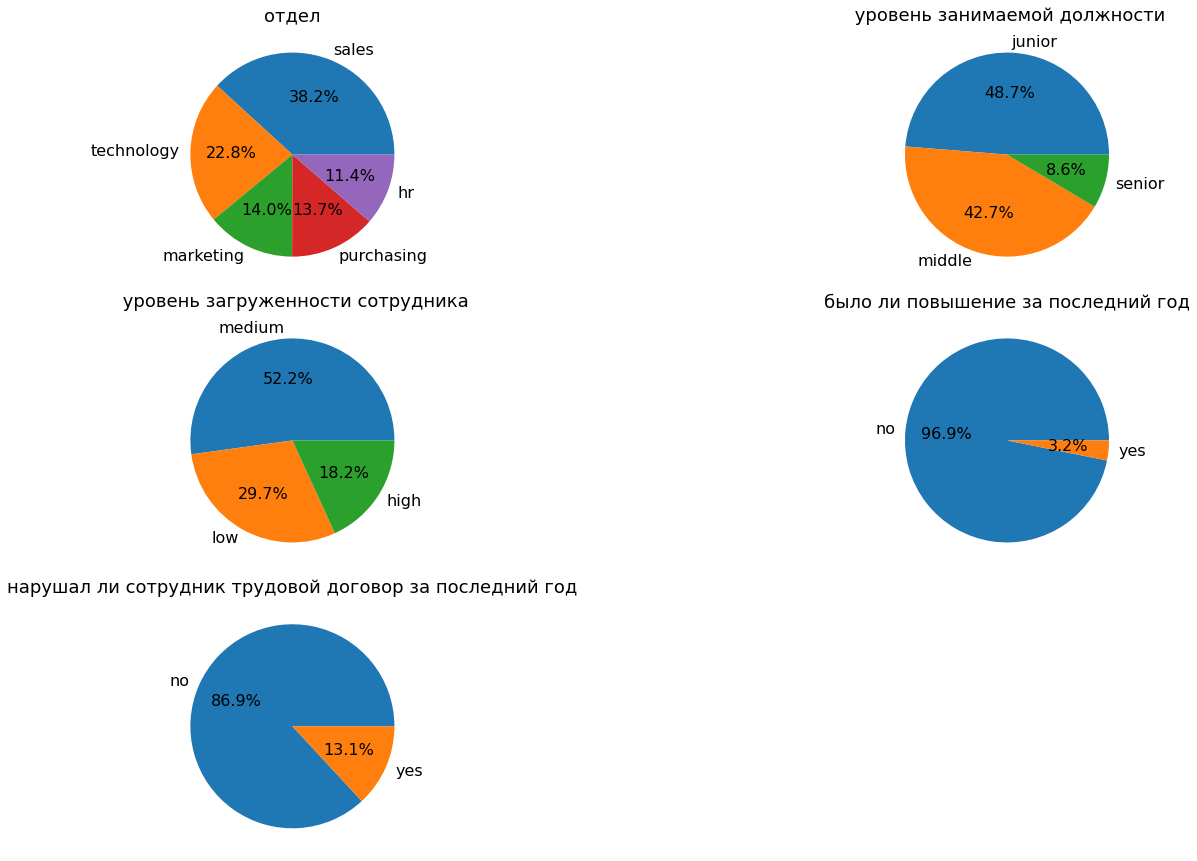

------------------------------------------------------------------------------------------------------------------------
, y_test


,job_satisfaction_rate
count,2000.00000
mean,0.54878
std,0.22011
min,0.03000
25%,0.38000
50%,0.58000
75%,0.72000
max,1.00000


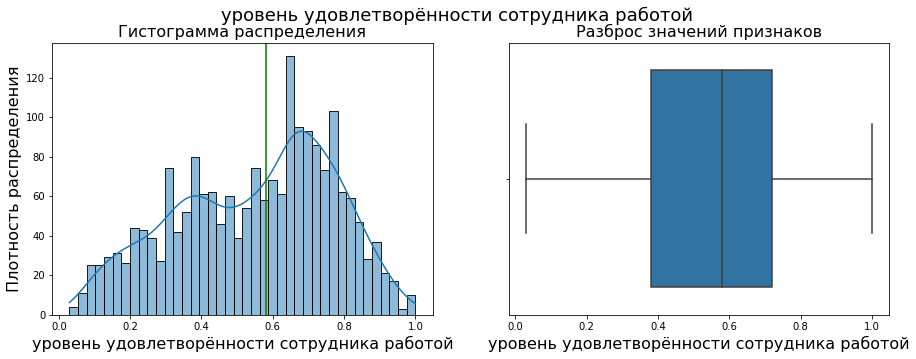

------------------------------------------------------------------------------------------------------------------------


In [22]:
count = 0
for df in df_list:
    print(f"\033[1m {df_list_name[count]}\033[0m")
    display(df.describe())
    graph_num_df(df)
    graph_cat_df(df)
    print('-' * 120)
    count += 1

In [23]:
# функция для построения матрицы корреляции
def phik_plot(df, interval_col):
    phik_overview = df.phik_matrix(interval_cols=interval_col) 


    plot_correlation_matrix(
        phik_overview.values,
        x_labels=phik_overview.columns,
        y_labels=phik_overview.index,
        vmin=0, vmax=1, color_map='coolwarm',
        title=r'correlation $\phi_K$',
        fontsize_factor=1.5,
        figsize=(20, 15)
    ) 

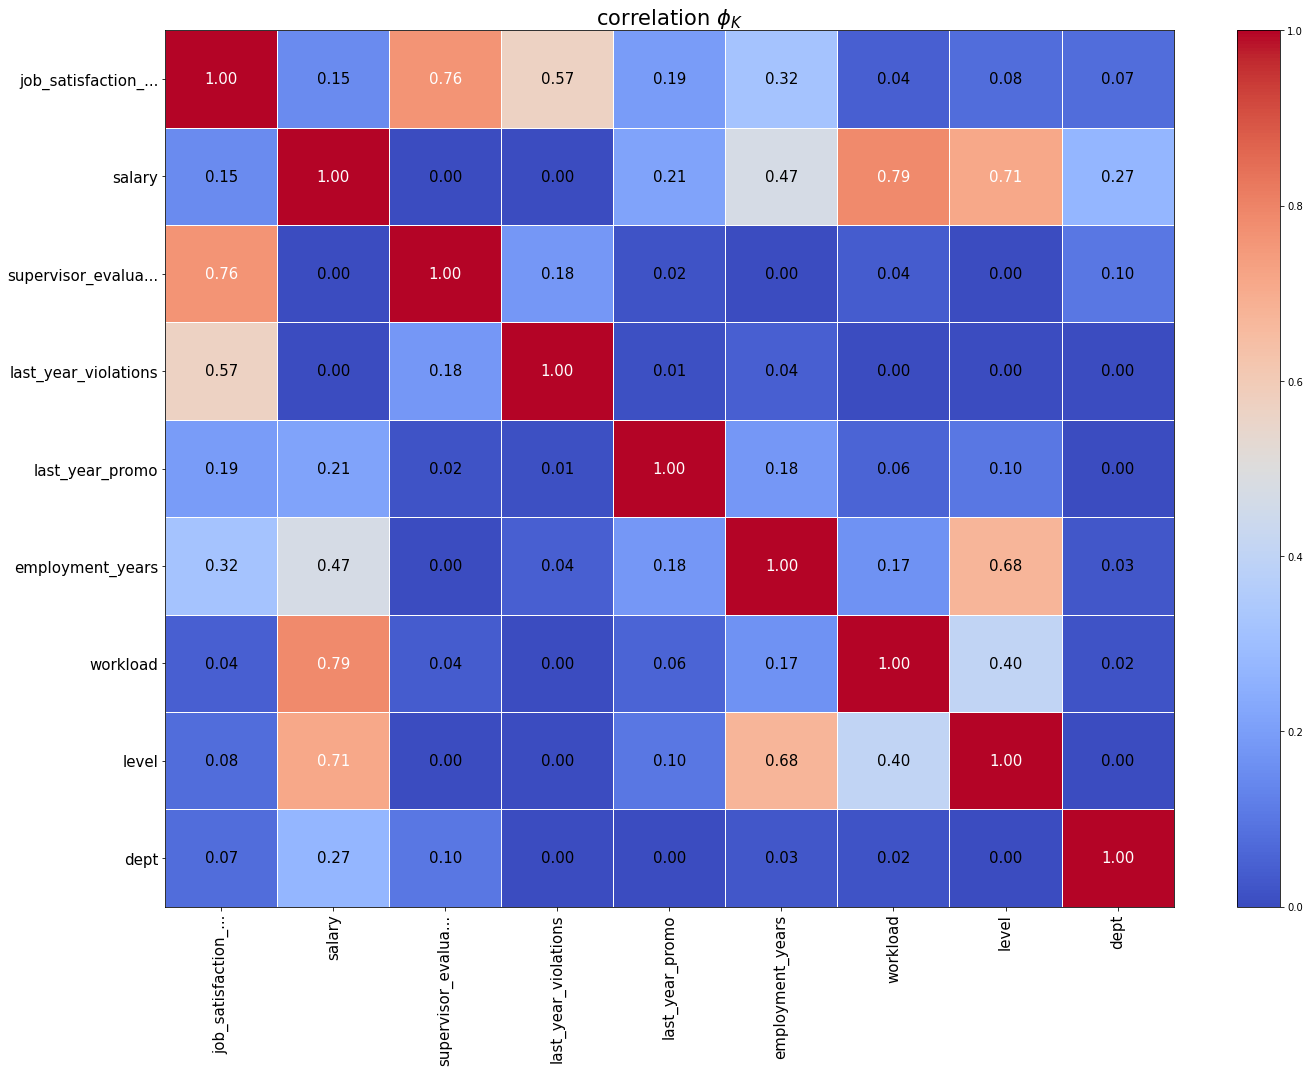

In [24]:
# построим матрицу корреляции для тренировочных данных
interval_cols  = ['salary', 'job_satisfaction_rate']
phik_plot(train_df, interval_cols)

In [25]:
X_y_test = X_test.merge(y_test, right_index=True, left_index=True)
X_y_test.shape

(2000, 9)

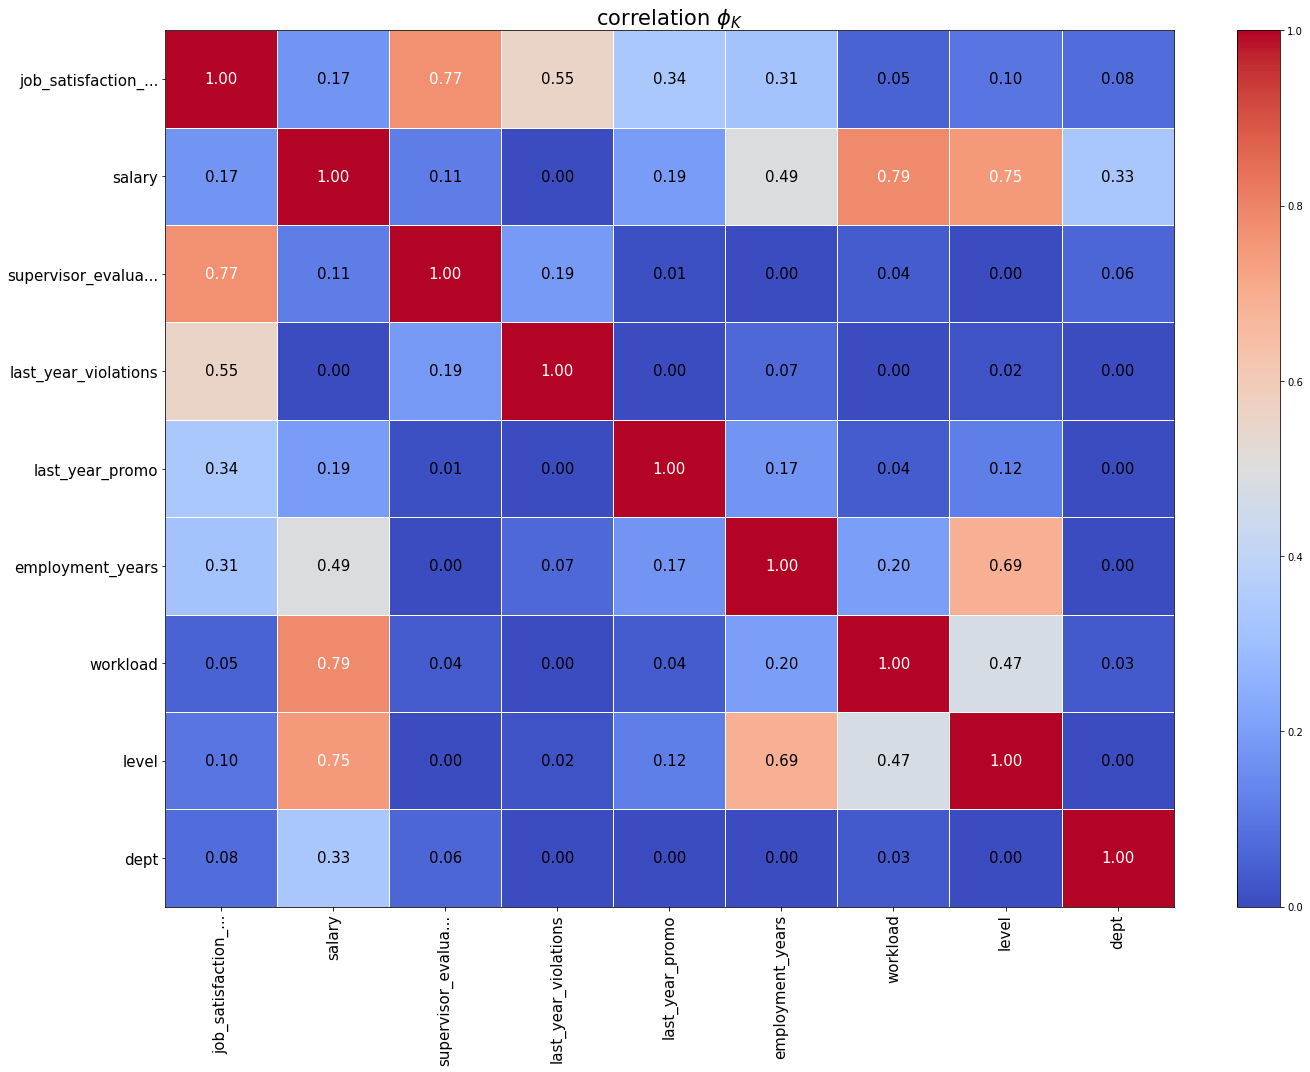

In [26]:
# построим матрицу корреляции для тестовых данных
phik_plot(X_y_test, interval_cols)

level имеет положительную корреляцию с salary и employment_years. Workload положительно коррелирует с salary.
Таргет сильно коррелирует с supervisor_evaluation.

#### Вывод

В рамках данного этапа были построены графики для каждого датасета. Для количественных признаков простроены гистограммы и боксплоты. Для категориальных признаков - круговые диаграммы. 

Выбросов и аномалий в данных не обнаружено. 

Проведено сравнение тестовой и тренировочной выборки - данные имеют одинаковое соотношение.

**Анализ признаков:**

- В отделе продаж больше всего сотрудников.


- Сотрудников с уровнем junior и middle больше всего.


- У половины сотрудников средний уровень загруженности.


- Большая часть сотрудников работает в компании 1 - 2 года.


- Руководитель чаще всего выставляет сотрудникам оценки 3 и 4.


- 3% сотрудников получили повышение за последний год.


- ~ 14% нарушали трудовой договор за последний год.


- Зарплата большинства сотрудников от 12000 до 43000 рублей.


- Соотношение довольных и недовольных работой примерно равно.


level имеет положительную корреляцию с salary и employment_years. Workload положительно коррелирует с salary.
Таргет сильно коррелирует с supervisor_evaluation. Связь нигде не превышает 0.9, так что менять ничего не будем.

Для подготовки признаков будем использовать:

**MinMaxScaler/StandartScaler** для стобцов **employment_years, salary, supervisor_evaluation** - количественные признаки

**OrdinalEncode**r для столбцов **level, workload** - порядковые признаки

**OneHotEncoder** для столбцов **dept, last_year_promo, last_year_violations** - категориальные признаки

### Подготовка данных

In [27]:
# Выделим столбцы для разного типа обработки
ohe_columns = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['supervisor_evaluation', 'employment_years', 'salary']

In [28]:
# выделяем отдельно таргет и входные признаки
X_train = train_df.drop(['job_satisfaction_rate'], axis = 1)
y_train = train_df['job_satisfaction_rate']

RANDOM_STATE = 42

In [29]:
# Пайплайн с обработкой категориальных значений и пропущенных значений
ohe_pipe = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

In [30]:
# Пайплайн с обработкой порядковых значений и пропущенных значений
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [31]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

Мы создали пайплайн для подготовки данных. В следующем шаге напишем итоговый пайплайн для подбора лучшей модели и гиперпараметров к ним, а также применим пайплайн для подготовки признаков.

### Обучение моделей

In [32]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [33]:
# Несколько моделей и несколько параметров
param_grid = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(10,25),
        'models__min_samples_split': range(2, 10),
        'models__min_samples_leaf': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [34]:
# функция для вычисления smape
def smape_score(y_true, y_pred):
    s = abs(y_true-y_pred)/((abs(y_true)+abs(y_pred))/2)
    
    return (100/len(y_true)) * sum(s)

In [35]:
# создаем метрику
smape = make_scorer(smape_score, greater_is_better=False)

In [36]:
# игнорирует все future warnings
simplefilter(action='ignore', category=FutureWarning)

In [37]:
# случайный поиск гиперпараметров
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    random_state=RANDOM_STATE,
    scoring=smape, 
    n_jobs=-1
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                         'models__min_samples_leaf': range(1, 6),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape_score, greater_is_better=False))

In [38]:
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 


,Лучшая модель и её параметры:
,
, Pipeline(steps=[('preprocessor',
,                 ColumnTransformer(remainder='passthrough',
,                                   transformers=[('ohe',
,                                                  Pipeline(steps=[('simpleImputer_ohe',
,                                                                   SimpleImputer(strategy='most_frequent')),
,                                                                  ('ohe',
,                                                                   OneHotEncoder(drop='first',
,                                                                                 handle_unknown='ignore',
,                                                                                 sparse=False))]),
,                                                  ['dept', 'last_year_promo',
,                                                   'last_year_violations']),
,                                                 ('ord',
,                   

In [39]:
print('Метрика SMAPE для лучшей модели:\n', -randomized_search.best_score_)

Метрика SMAPE для лучшей модели:
, 15.203574482949088


Лучшая модель DecisionTreeRegressor(max_depth=23, min_samples_leaf=3, min_samples_split=8, random_state=42). Проверим её качество на тестовой выборке.

In [40]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()

In [41]:
y_pred = randomized_search.predict(X_test)

In [42]:
print('Значение метрики SMAPE на тестовых данных:', smape_score(np.array(y_test['job_satisfaction_rate']), y_pred))

Значение метрики SMAPE на тестовых данных: 13.346539579679973


Критерий успеха: SMAPE ≤ 15 на тестовой выборке.

Значение метрики меньше 15, а значит модель работает успешно

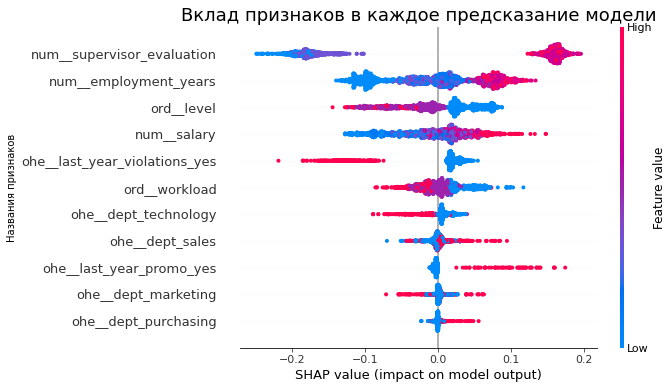

In [43]:
# Проведем анализ важности признаков при помощи значений Шелпи
X_train = pipe_final.named_steps['preprocessor'].fit_transform(X_train)
X_test_1 = pipe_final.named_steps['preprocessor'].transform(X_test)

explainer = shap.TreeExplainer(randomized_search.best_estimator_.named_steps['models'])

feature_names = pipe_final.named_steps['preprocessor'].get_feature_names_out()
X_test_1 = pd.DataFrame(X_test_1, columns=feature_names)

shap_values = explainer(X_test_1)

shap.plots.beeswarm(shap_values, show=False, max_display=12)

plt.rcParams['font.size'] = '15'
plt.title('Вклад признаков в каждое предсказание модели')
plt.ylabel('Названия признаков')
plt.show()

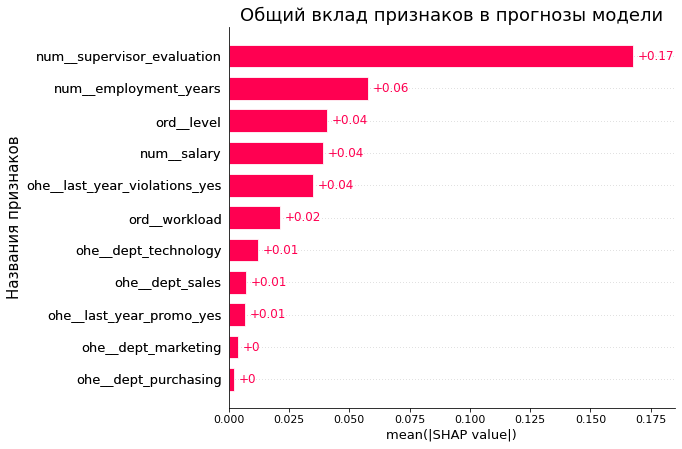

In [44]:
shap.plots.bar(shap_values,show=False, max_display=12)
plt.rcParams['font.size'] = '15'
plt.title('Общий вклад признаков в прогнозы модели')
plt.ylabel('Названия признаков')
plt.show()

Оценка руководителя больше всего влияет на удовлетворенность сотрудника работой.

### Промежуточные выводы

Задача 1 выполнена. Была построена модель, которая предсказывает уровень удовлетворенности сотрудников на основе данных, что предоставил заказчик.

**Подготовка данных:**

- Порядковые переменные level и workload кодировали с помощью OrdinalEncoder
- Категориальные переменные dept, last_year_promo, last_year_violations кодировали с помощью OneHotEncoder
- Количественные - employment_years, salary, supervisor_evaluation  маштабировали, используя StandardScaler

**Лучшей моделью** стала **DecisionTreeRegressor**(max_depth=23, min_samples_leaf=3, min_samples_split=8, random_state=42).

**Значение метрики** на тестовой выборке составляет **13.35**, что является успехом

Линейная регрессия сильно зависит от выбросов и масштабирования. Дерево решений в этом плане устойчивее, также оно ищет взаимосвязи, которые упускает линейная регрессия.

Исходя из матрицы корреляции, у нас много признаков с нелинейной зависимостью, поэтому дерево справилось лучше. 

## Задача 2: предсказание увольнения сотрудника из компании

### Загрузка данных

In [45]:
try:
    train_quit_df = pd.read_csv('train_quit.csv.csv') 
    y_test_quit = pd.read_csv('test_target_quit.csv')
except:
    train_quit_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv') 
    y_test_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv')

In [46]:
df_list_2 = [train_quit_df, y_test_quit]

In [47]:
df_print(df_list_2)

,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
3535,982270,hr,middle,medium,5,no,no,4,34800,no
1895,845600,hr,middle,medium,7,no,no,2,38400,no
2201,788571,sales,junior,low,1,no,yes,3,14400,yes
86,609391,sales,middle,medium,6,no,yes,4,43200,no
1492,837352,hr,middle,medium,2,no,yes,3,39600,no
971,780738,hr,junior,medium,2,no,no,3,22800,no
1486,115528,marketing,junior,medium,1,no,no,3,24000,yes
3059,654331,sales,sinior,high,10,no,yes,4,64800,no
1954,541688,sales,middle,high,5,no,no,4,49200,no
2845,712275,hr,junior,high,2,no,yes,4,33600,yes


,id,quit
1818,284552,no
1293,771859,no
464,827231,no
483,482281,no
1780,622990,no
806,370373,yes
822,820538,yes
1107,719276,no
1876,276706,no
1094,950627,no


In [48]:
df_info(df_list_2)

<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 4000 entries, 0 to 3999
,Data columns (total 10 columns):
, #   Column                 Non-Null Count  Dtype 
,---  ------                 --------------  ----- 
, 0   id                     4000 non-null   int64 
, 1   dept                   4000 non-null   object
, 2   level                  4000 non-null   object
, 3   workload               4000 non-null   object
, 4   employment_years       4000 non-null   int64 
, 5   last_year_promo        4000 non-null   object
, 6   last_year_violations   4000 non-null   object
, 7   supervisor_evaluation  4000 non-null   int64 
, 8   salary                 4000 non-null   int64 
, 9   quit                   4000 non-null   object
,dtypes: int64(4), object(6)
,memory usage: 312.6+ KB
,
,
,<class 'pandas.core.frame.DataFrame'>
,RangeIndex: 2000 entries, 0 to 1999
,Data columns (total 2 columns):
, #   Column  Non-Null Count  Dtype 
,---  ------  --------------  ----- 
, 0   id      2000 non-nul

#### Вывод

1. Данные в таблицах соответствуют описанию.
2. Названия колонок в общепринятом стиле.
3. Верные типы данных.
4. На данном этапе не выявлено пропусков.

### Предобработка данных

In [49]:
for df in df_list_2:
    df.set_index('id', inplace=True)

In [50]:
df_list_name_2 = ['train_quit_df', 'y_test_quit']

In [51]:
misprint_df(df_list_2, df_list_name_2)

train_quit_df ['sales', 'purchasing', 'marketing', 'technology', 'hr']
,train_quit_df ['middle', 'junior', 'sinior']
,train_quit_df ['high', 'medium', 'low']
,train_quit_df ['no', 'yes']
,train_quit_df ['no', 'yes']
,train_quit_df ['no', 'yes']
,y_test_quit ['yes', 'no']


In [52]:
train_quit_df ['level'] = train_quit_df ['level'].replace('sinior', 'senior', regex=True)

In [53]:
train_quit_df['level'].unique()

array(['middle', 'junior', 'senior'], dtype=object)

In [54]:
skip_and_dup(df_list_2, df_list_name_2)

------------------------------
,	train_quit_df
,
,дубликаты: 1413
,
,пропуски:
,dept                     0
,level                    0
,workload                 0
,employment_years         0
,last_year_promo          0
,last_year_violations     0
,supervisor_evaluation    0
,salary                   0
,quit                     0
,dtype: int64
,------------------------------
,	y_test_quit
,
,дубликаты: 1998
,
,пропуски:
,quit    0
,dtype: int64


In [55]:
train_quit_df = train_quit_df.drop_duplicates()
train_quit_df.shape

(2587, 9)

#### Вывод

- Были обнаружены пропуски, которые обработаем в пайплайне в следующих шагах.


- Дубликаты обнаружены и удалены в тренировочной выборке. Дубликаты в тестовых выборках удалять не будем, на качество обучения модели они не повлияют.


- Была исправлена опечатка в слове "senior".


- Неявных дубликатов не выявлено.

### Исследователький анализ данных

#### Исследуем все признаки

In [56]:
# так как входные признаки тестовой выборки те же, что и в прошлой задаче, то сохраним копию
X_test_2 = X_test.copy()

In [57]:
df_list_2 = [train_quit_df, X_test_2, y_test_quit]
df_list_name_2 = ['train_quit_df', 'X_test_2', 'y_test_quit']

In [58]:
# добавляю в свой словарь новый признак
dict_list['quit'] = 'уволился'

 train_quit_df


,employment_years,supervisor_evaluation,salary
count,2587.000000,2587.000000,2587.000000
mean,4.213375,3.367994,37107.692308
std,2.601105,1.080243,16267.354906
min,1.000000,1.000000,12000.000000
25%,2.000000,3.000000,24000.000000
50%,4.000000,3.000000,33600.000000
75%,6.000000,4.000000,46800.000000
max,10.000000,5.000000,96000.000000


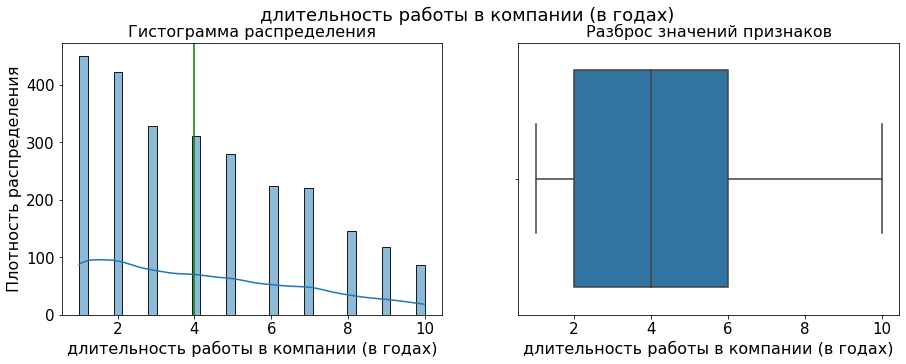

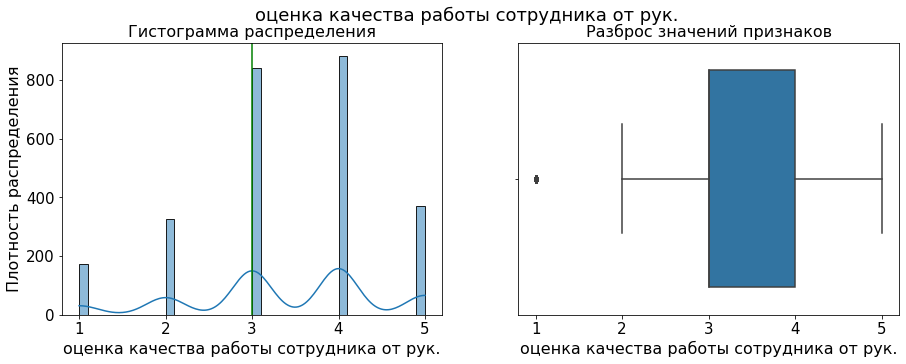

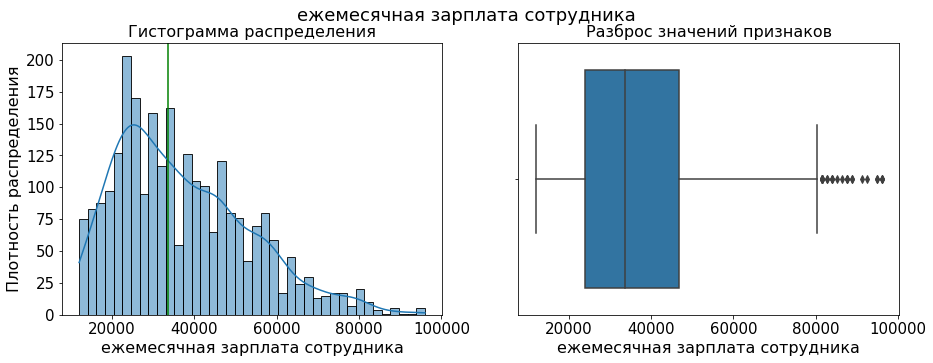

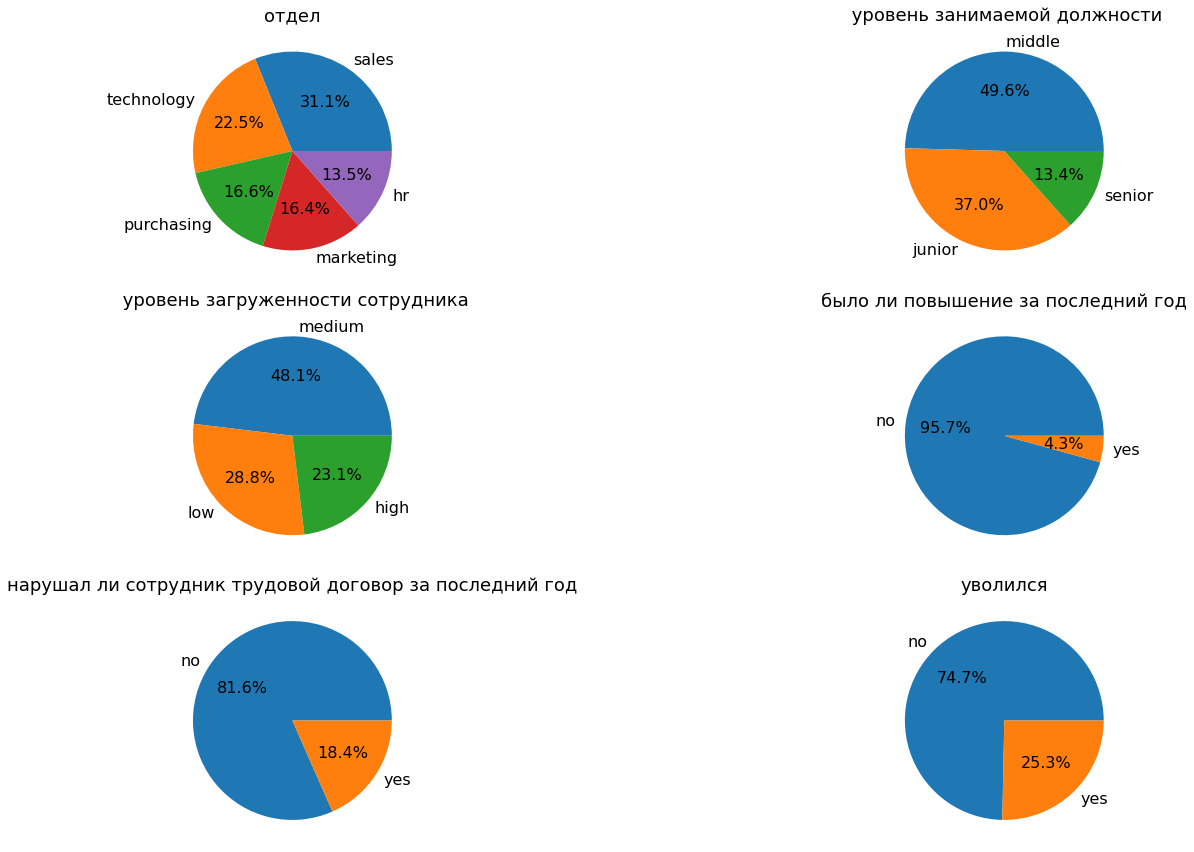

------------------------------------------------------------------------------------------------------------------------
, X_test_2


,employment_years,supervisor_evaluation,salary
count,2000.000000,2000.000000,2000.000000
mean,3.666500,3.526500,34066.800000
std,2.537222,0.996892,15398.436729
min,1.000000,1.000000,12000.000000
25%,1.000000,3.000000,22800.000000
50%,3.000000,4.000000,30000.000000
75%,6.000000,4.000000,43200.000000
max,10.000000,5.000000,96000.000000


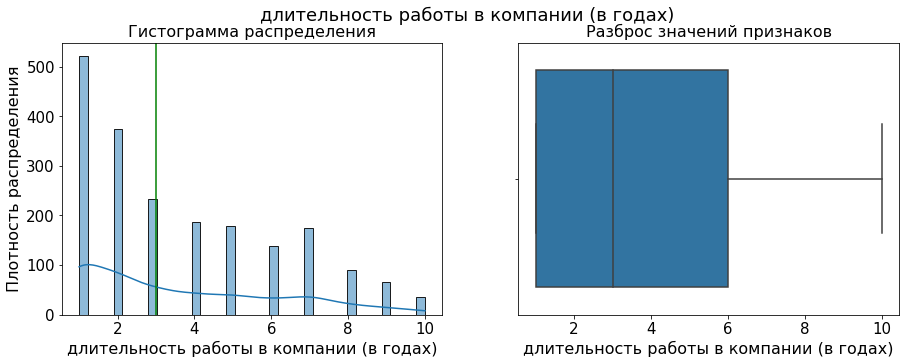

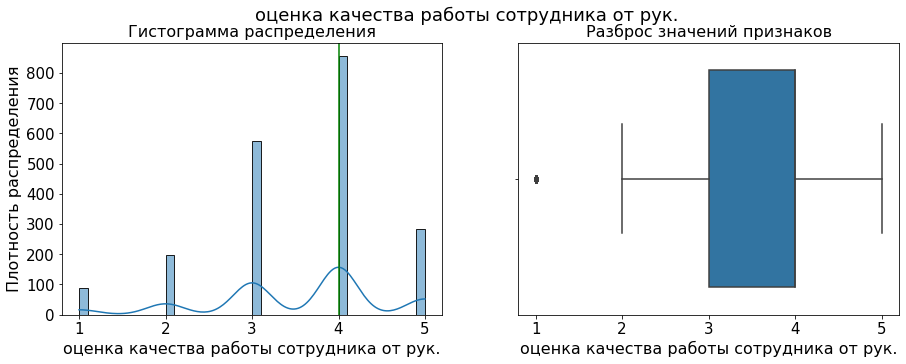

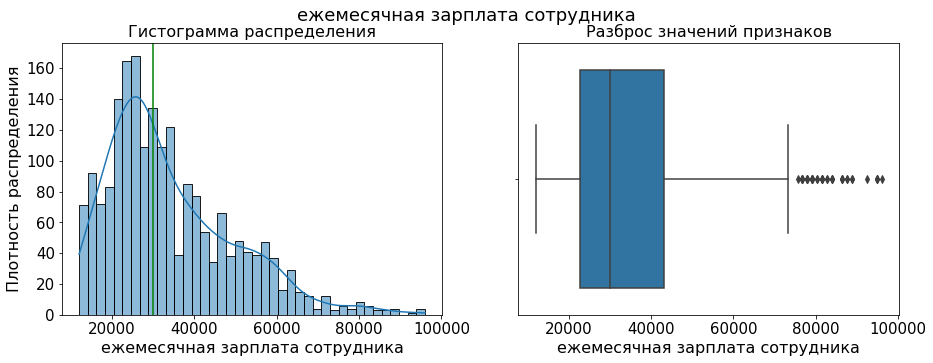

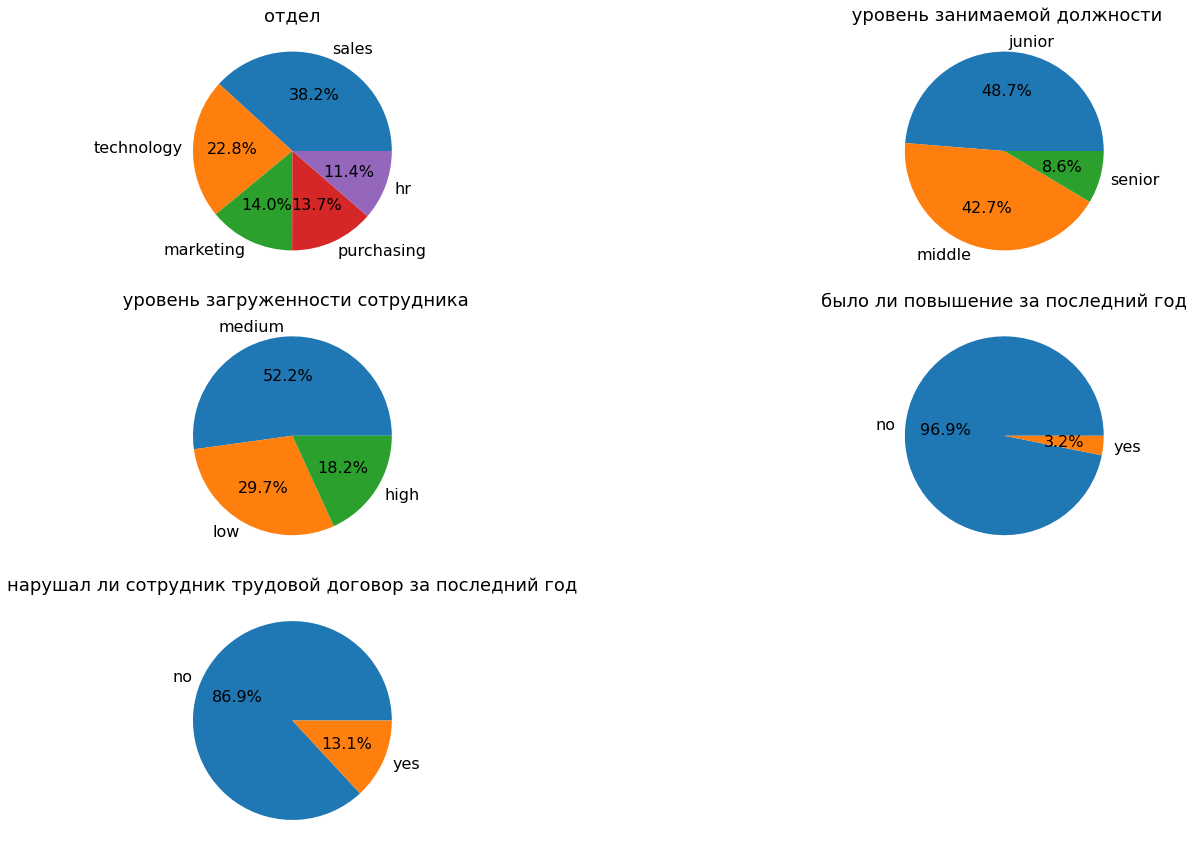

------------------------------------------------------------------------------------------------------------------------
, y_test_quit


,quit
count,2000
unique,2
top,no
freq,1436


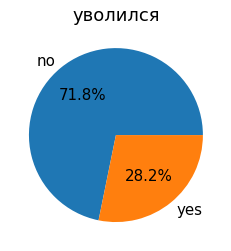

------------------------------------------------------------------------------------------------------------------------


In [59]:
count = 0
for df in df_list_2:
    print(f"\033[1m {df_list_name_2[count]}\033[0m")
    display(df.describe())
    graph_num_df(df)
    graph_cat_df(df)
    print('-' * 120)
    count += 1

##### Вывод

В рамках данного этапа были построены графики для каждого датасета. Для количественных признаков простроены гистограммы и боксплоты. Для категориальных признаков - круговые диаграммы.

Выбросов и аномалий в данных не обнаружено.

Проведено сравнение тестовой и тренировочной выборки - данные имеют одинаковое соотношение.

Анализ показал, что выводы, сделанные для признаков на этапе исследовательского анализа первой задачи, также справедливы и для текущих данных.

Присутствует дисбаланс классов: более 70% - это уволившиеся сотрудники.

#### Портрет «уволившегося сотрудника»

In [60]:
# Разделим тренировочную выборку на две группы: оставшиеся и уволившиеся сотрудники
quit_yes = train_quit_df[train_quit_df['quit'] == 'yes']
quit_no = train_quit_df[train_quit_df['quit'] == 'no']

In [61]:
# функция для построения круговой диаграммы для категориальных признаков 
def pie_plot(df1, df2, k):
    fig, axes = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(18, 5)
    fig.suptitle(dict_list[k])

    df1[k].value_counts().plot(kind='pie', subplots=True, autopct='%.1f%%', legend=False, ax=axes[0])
    axes[0].set_axis_off()
    axes[0].set_title('Уволившиеся сотрудники')

    df2[k].value_counts().plot(kind='pie', subplots=True, autopct='%.1f%%', legend=False, ax=axes[1])
    axes[1].set_axis_off()
    axes[1].set_title('Оставшиеся сотрудники')
    plt.subplots_adjust(top= 0.8)
    plt.show()

In [62]:
# функция для построения гистрограммы и боксплота
def graph_num_df_2(df, k, i):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    fig.suptitle(dict_list[k])
    
    sns.histplot(data=df, x=k, ax=axes[0], bins=40, kde=True)
    axes[0].axvline(x=df[k].describe().T["50%"], color='g')
    axes[0].set_title(i)
    axes[0].set_xlabel('Зарплата в рублях')
    axes[0].set_ylabel('Плотность распределения сотрудников')
        
       
    sns.boxplot(data=df, x=k, ax=axes[1])
    axes[1].set_ylabel('Зарплата в рублях')
    axes[1].set_title(i)
    plt.subplots_adjust(top= 0.8)
    plt.show()

In [63]:
list_cols = [
    'dept',
    'level',
    'workload',
    'last_year_promo',
    'last_year_violations',
    'supervisor_evaluation'
]

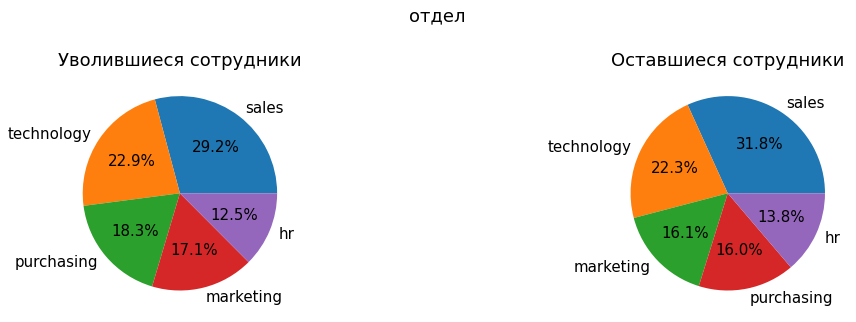

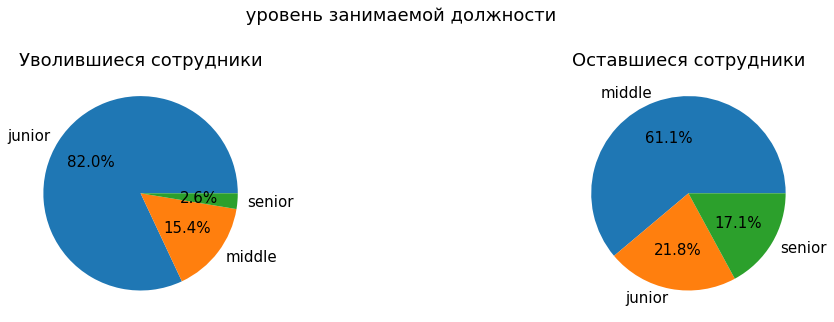

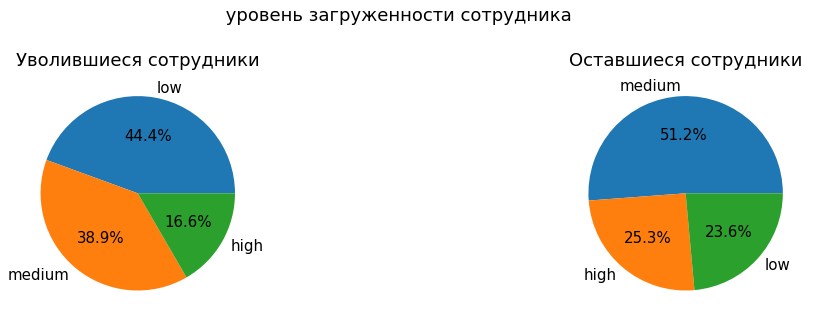

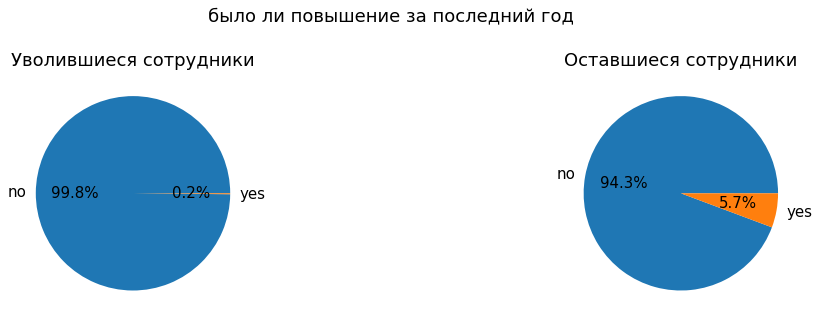

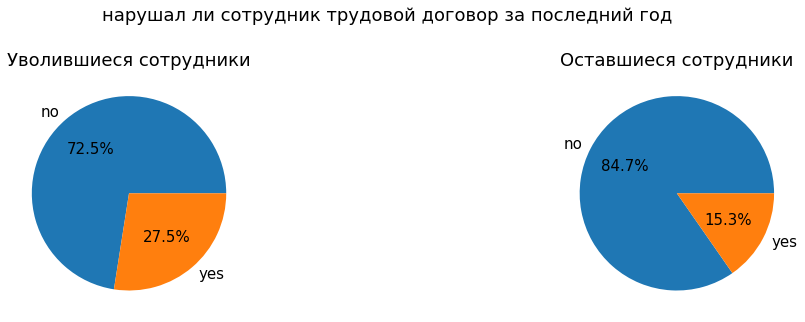

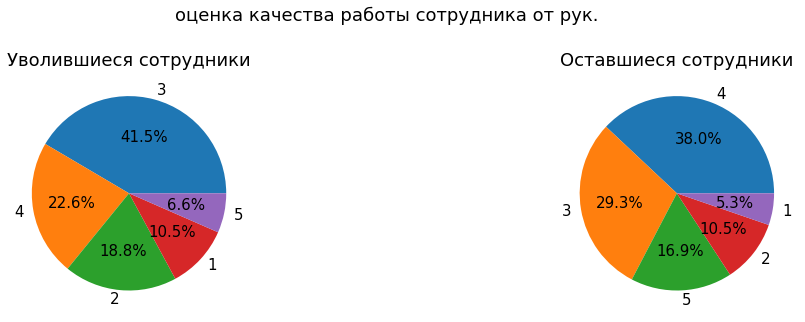

In [64]:
for k in list_cols:
    pie_plot(quit_yes, quit_no, k)

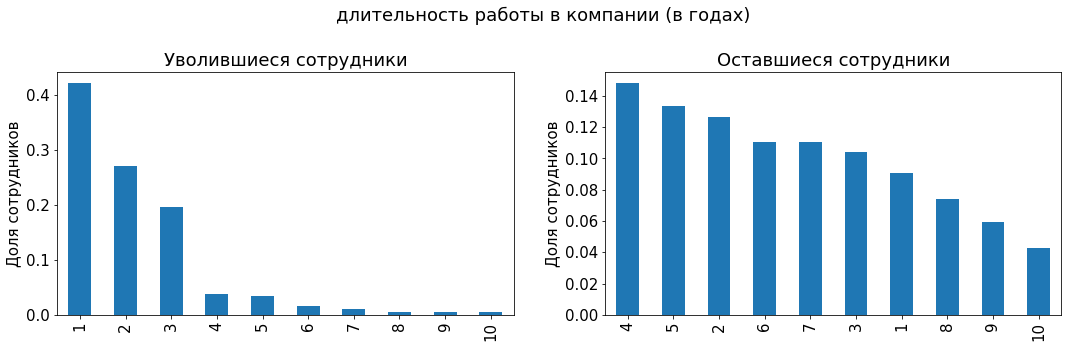

In [65]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18, 5)
fig.suptitle(dict_list['employment_years'])

quit_yes['employment_years'].value_counts(normalize=True).plot(kind='bar', ax=axes[0])
axes[0].set_title('Уволившиеся сотрудники')
axes[0].set_ylabel('Доля сотрудников')

quit_no['employment_years'].value_counts(normalize=True).plot(kind='bar', ax=axes[1])
axes[1].set_title('Оставшиеся сотрудники')
axes[1].set_ylabel('Доля сотрудников')
plt.subplots_adjust(top=0.8)
plt.show()

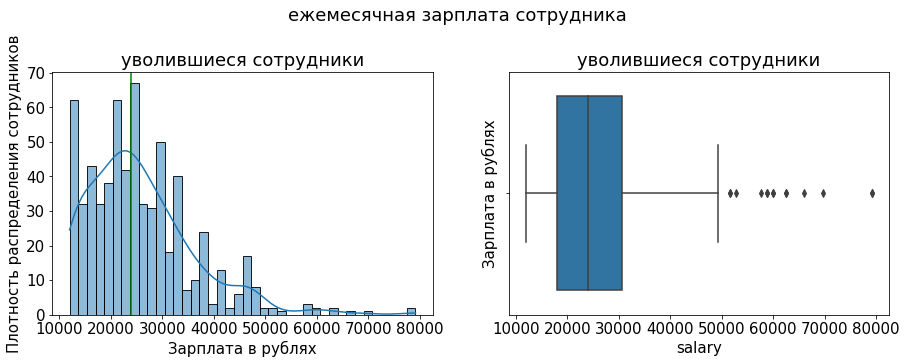

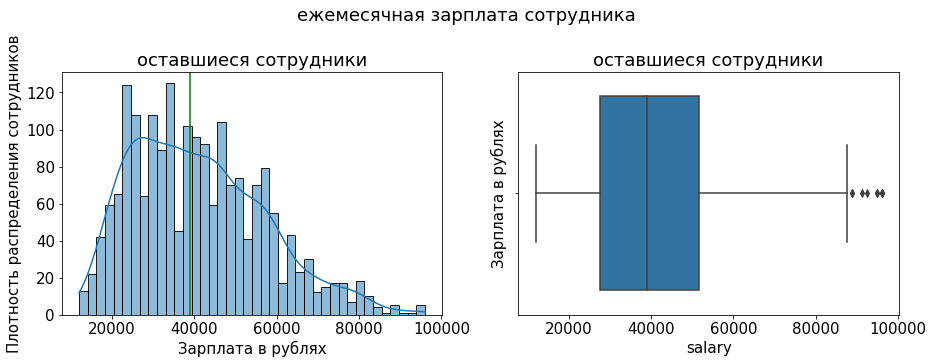

In [66]:
graph_num_df_2(quit_yes, 'salary', 'уволившиеся сотрудники')
graph_num_df_2(quit_no, 'salary', 'оставшиеся сотрудники')

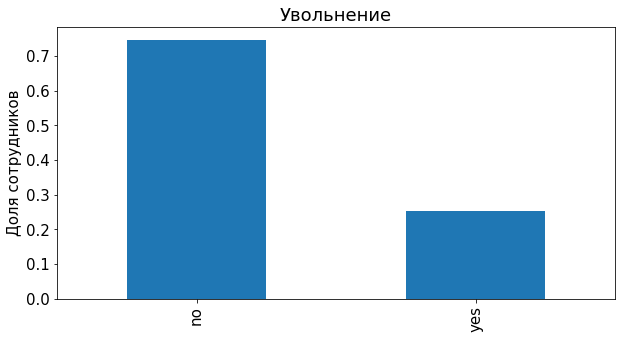

In [67]:
train_quit_df['quit'].value_counts(normalize=True).plot(kind='bar',figsize=(10,5))
plt.title('Увольнение')
plt.ylabel('Доля сотрудников')
plt.show()

##### Вывод

Портрет «уволившегося сотрудника:

1. Распределение по отделам почти равномерное, немного больше ушло из отдела sales.
2. В 82% - уровень junior.
3. Загрузка чаще всего low и medium.
4. Стаж в компании от 1 до 3х лет.
5. Повышения за последний год почти никто не получил.
6. более 70% не нарушали трудовой договор ща последний год.
7. В основм от руководителя получают оценку 3, чуть меньшее количество - 4.
8. Средняя зааботная плата примерно 23000.

#### Распределения признака "job_satisfaction_rate" для ушедших и оставшихся сотрудников

In [68]:
X_test_2 = X_test_2.sort_index()
y_test_quit = y_test_quit.sort_index()
y_test = y_test.sort_index()

In [69]:
X_test_new = X_test_2
X_test_new['job_satisfaction_rate'] = y_test['job_satisfaction_rate']
X_test_new['quit'] = y_test_quit['quit']

In [70]:
X_test_new.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.80,no
100480,marketing,junior,low,4,no,no,4,16800,0.84,no
100503,purchasing,middle,high,5,no,no,4,55200,0.79,no
100610,sales,middle,medium,5,no,no,4,43200,0.75,no
100692,sales,middle,high,6,no,no,4,48000,0.69,no


In [71]:
new_quit_yes = X_test_new[X_test_new['quit'] == 'yes']
new_quit_no = X_test_new[X_test_new['quit'] == 'no']

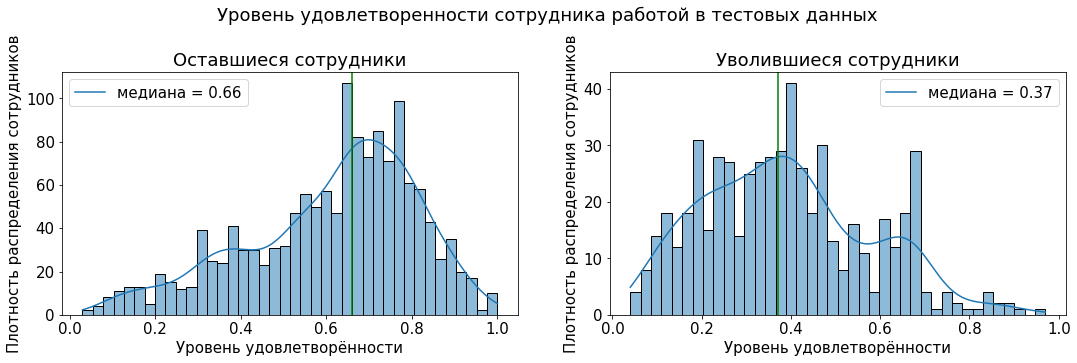

In [72]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.set_size_inches(18, 5)
fig.suptitle('Уровень удовлетворенности сотрудника работой в тестовых данных')

sns.histplot(data=new_quit_no, x='job_satisfaction_rate', ax=axes[0], bins=40, kde=True)
axes[0].axvline(x=new_quit_no['job_satisfaction_rate'].describe().T["50%"], color='g')
axes[0].set_title('Оставшиеся сотрудники')
axes[0].set_xlabel('Уровень удовлетворённости')
axes[0].set_ylabel('Плотность распределения сотрудников')
axes[0].legend(['медиана = ' + str(new_quit_no['job_satisfaction_rate'].describe().T['50%'])])

sns.histplot(data=new_quit_yes, x='job_satisfaction_rate', ax=axes[1], bins=40, kde=True)
axes[1].axvline(x=new_quit_yes['job_satisfaction_rate'].describe().T["50%"], color='g') 
axes[1].set_title('Уволившиеся сотрудники')
axes[1].set_xlabel('Уровень удовлетворённости')
axes[1].set_ylabel('Плотность распределения сотрудников')
axes[1].legend(['медиана = ' + str(new_quit_yes['job_satisfaction_rate'].describe().T['50%'])])

plt.subplots_adjust(top=0.8)
plt.show()

##### Вывод

У оставшихся сотрудников уровень удовлетворенности в среднем 0.66, у уволившихся - 0.37. Отсюда можно сделать вывод, что уровень удовлетворённости сотрудника работой в компании влияет на то, уволится ли сотрудник.

### Добавление нового входного признака

In [73]:
# Добавим job_satisfaction_rate, предсказанный лучшей моделью первой задачи, к входным признакам второй задачи
train_quit_df['job_satisfaction_rate'] = randomized_search.predict(train_quit_df.drop(['quit'], axis=1))
X_test_2['job_satisfaction_rate'] = randomized_search.predict(X_test_2)

In [74]:
X_test_2.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate,quit
id,,,,,,,,,,
100298,hr,junior,low,2,no,no,4,19200,0.83125,no
100480,marketing,junior,low,4,no,no,4,16800,0.85200,no
100503,purchasing,middle,high,5,no,no,4,55200,0.81750,no
100610,sales,middle,medium,5,no,no,4,43200,0.81400,no
100692,sales,middle,high,6,no,no,4,48000,0.69600,no


In [75]:
train_quit_df.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.605000
814010,sales,junior,medium,2,no,no,4,27600,no,0.846364
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.337500
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.350000
910140,marketing,junior,medium,2,no,no,5,25200,no,0.791667


In [76]:
interval_cols  = ['salary', 'job_satisfaction_rate']

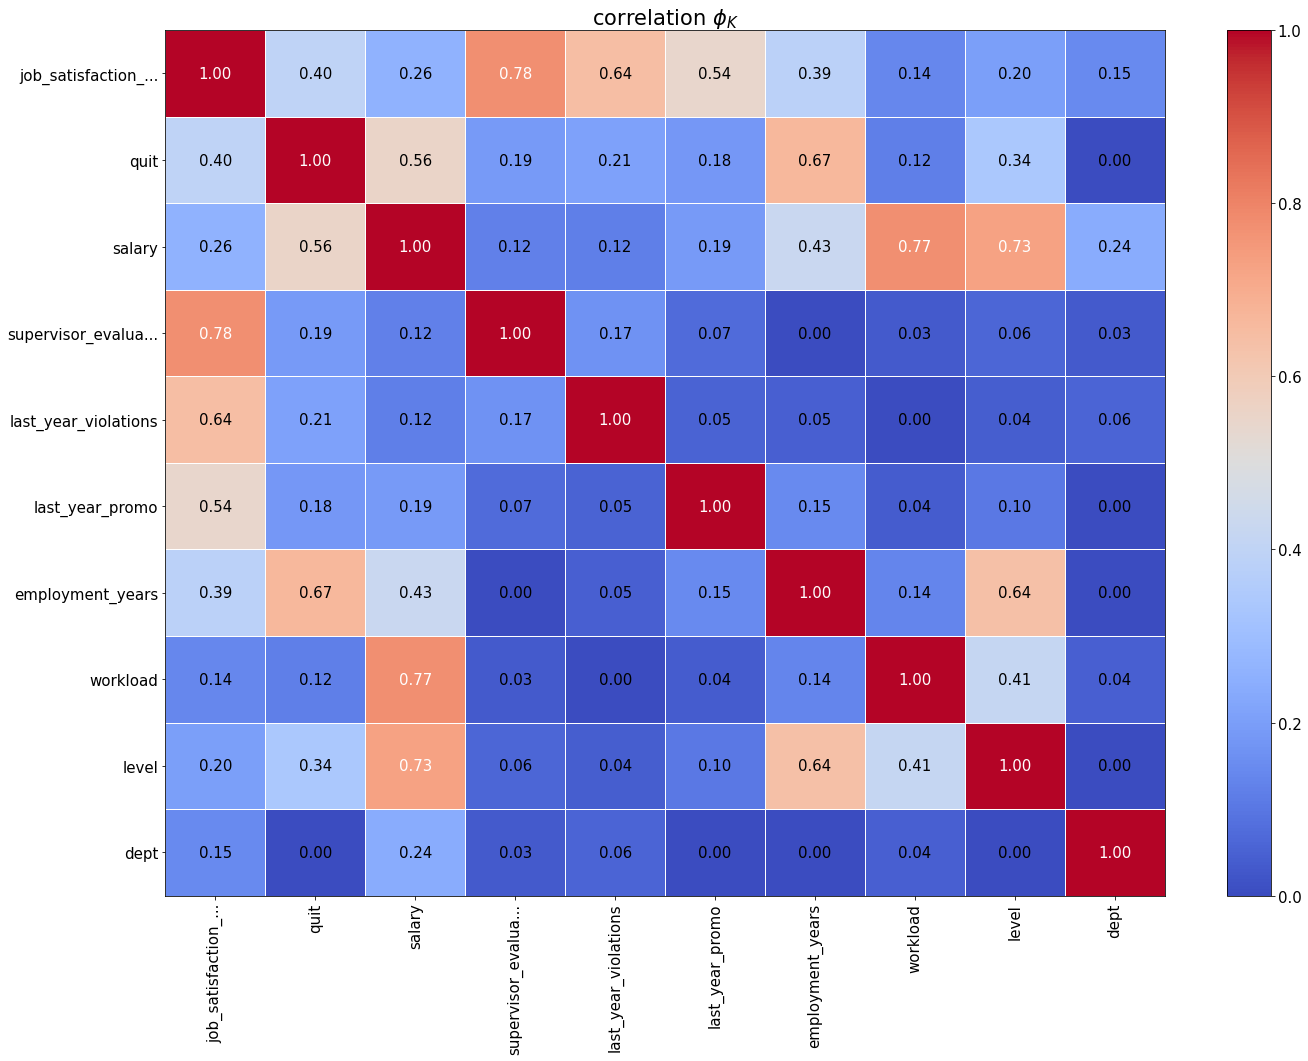

In [77]:
# тренировочная выборка
phik_plot(train_quit_df, interval_cols)

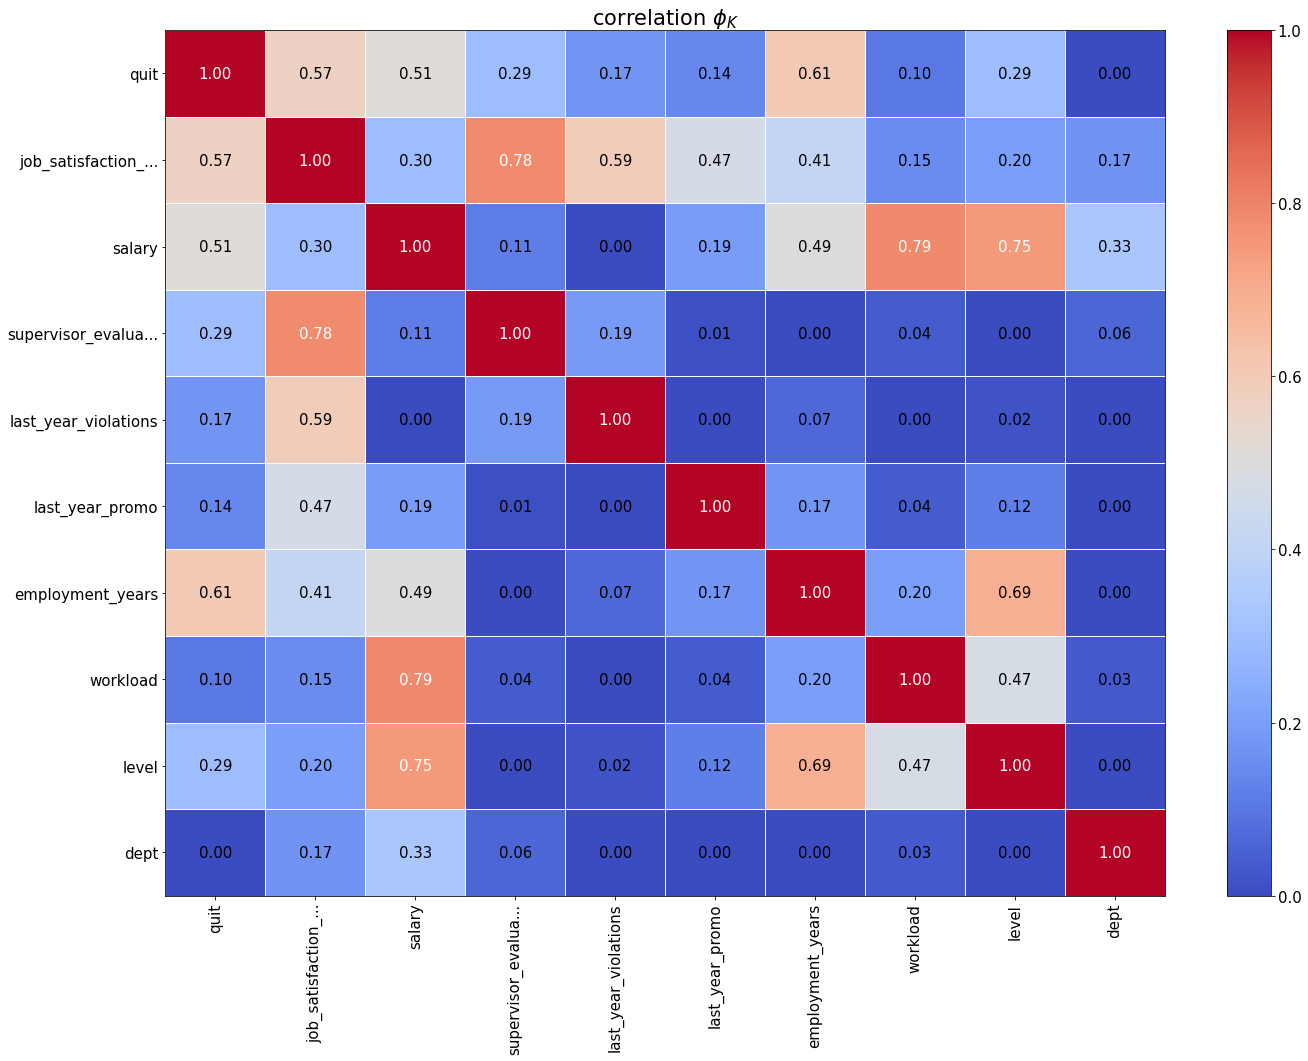

In [78]:
# тестовая выборка
phik_plot(X_test_2, interval_cols)

#### Вывод

Целевой признак имеет положительную корреляцию с признаками employment_years, salary и job_satisfaction_rate. 

Мультиколлинеарности в данных нет.

**Для подготовки признаков будем использовать:**

**MinMaxScaler/StandartScaler** для стобцов **employment_years, salary, supervisor_evaluation, job_satisfaction_rate** - количественные признаки

**OrdinalEncoder** для столбцов **level, workload** - порядковые признаки

**OneHotEncoder** для столбцов **dept, last_year_promo, last_year_violations** - категориальные признаки

### Подготовка данных

In [79]:
# Выделим столбцы для разного типа обработки
ohe_columns_2 = ['dept', 'last_year_promo',  'last_year_violations']
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['supervisor_evaluation', 'employment_years', 'salary', 'job_satisfaction_rate']

In [80]:
# выделяем отдельно таргет и входные признаки
X_train_2 = train_quit_df.drop(['quit'], axis = 1)
y_train_2 = train_quit_df['quit']

RANDOM_STATE = 42

In [81]:
# Закодируем целевой признак
label_encoder = LabelEncoder()

y_train_2 = label_encoder.fit_transform(np.ravel(y_train_2))
y_test_2 = label_encoder.transform(np.ravel(y_test_quit))

In [82]:
# Пайплайн с обработкой категориальных значений и пропущенных значений
ohe_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
        )
    ]
) 

In [83]:
# Пайплайн с обработкой порядковых значений и пропущенных значений
ord_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'],
                    ['low', 'medium', 'high']
                ], 
                handle_unknown='error'
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

In [84]:
data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_columns_2),
        ('ord', ord_pipe_2, ord_columns_2),
        ('num', MinMaxScaler(), num_columns_2)
    ], 
    remainder='passthrough'
) 

### Обучение модели

In [85]:
pipe_final_2= Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', LogisticRegression(random_state=RANDOM_STATE))
])

In [86]:
# Несколько моделей и несколько параметров
param_grid_2 = [
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 20),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler()]   
    },
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__max_features': range(2, 11),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    },
    {
        'models': [SVC(random_state=RANDOM_STATE, probability= True)],
        'models__C': range(1, 10),
        'models__kernel': ['rbf', 'linear', 'sigmoid'],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  

    },
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': range(1, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
] 

In [87]:
# случайный поиск гиперпараметров
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    scoring='roc_auc', 
    random_state=RANDOM_STATE,
    n_jobs=-1
)

randomized_search_2.fit(X_train_2, y_train_2)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(steps=...
                                                        random_state=42)],
                                         'models__C': range(1, 10),
                                         'models__kernel': ['rbf', 'linear',
                                                            'sigmoid'],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [88]:
print('\nЛучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_) 


,Лучшая модель и её параметры:
,
, Pipeline(steps=[('preprocessor',
,                 ColumnTransformer(remainder='passthrough',
,                                   transformers=[('ohe',
,                                                  Pipeline(steps=[('simpleImputer_ohe',
,                                                                   SimpleImputer(strategy='most_frequent')),
,                                                                  ('ohe',
,                                                                   OneHotEncoder(drop='first',
,                                                                                 handle_unknown='ignore',
,                                                                                 sparse=False))]),
,                                                  ['dept', 'last_year_promo',
,                                                   'last_year_violations']),
,                                                 ('ord',
,                   

In [89]:
print('Метрика roc_auc для лучшей модели:\n', randomized_search_2.best_score_)

Метрика roc_auc для лучшей модели:
, 0.8965763321474807


In [90]:
print('Метрика roc_auc для лучшей модели на тестовых данных:\n', roc_auc_score(y_test_2, 
                                                            randomized_search_2.predict_proba(X_test_2)[:,1]))

Метрика roc_auc для лучшей модели на тестовых данных:
, 0.9253417689010056


Лучшей моделью оказалось SVC(C=6, probability=True, random_state=42)

Критерий успеха: ROC-AUC ≥0.91 на тестовой выборке. 
Значение метрики ~0.93, а значит модель работает успешно.

In [91]:
X_train_shap = pd.DataFrame(
    pipe_final_2.named_steps['preprocessor'].fit_transform(X_train_2), 
    columns= pipe_final_2.named_steps['preprocessor'].get_feature_names_out()
)

X_test_shap = pd.DataFrame(
    pipe_final_2.named_steps['preprocessor'].transform(X_test_2), 
    columns= pipe_final_2.named_steps['preprocessor'].get_feature_names_out()
)
model = SVC(C=6, probability=True, random_state=42)
model.fit(X_train_shap, y_train_2)

explainer = shap.KernelExplainer(model.predict_proba, X_train_shap[:10])
shap_values = explainer(X_test_shap[:10])

  0%|          | 0/10 [00:00<?, ?it/s]

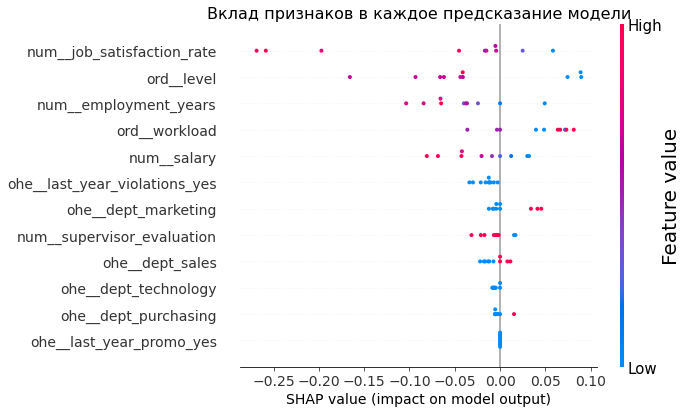

In [92]:
shap.plots.beeswarm(shap_values[:,:,1], show=False, max_display=12) 
fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel('SHAP value (impact on model output)', fontsize=14)
ax.set_title('Вклад признаков в каждое предсказание модели', fontsize=16)

cb_ax = fig.axes[1]

cb_ax.tick_params(labelsize=15)
cb_ax.set_ylabel('Feature value', fontsize=20)

plt.show()

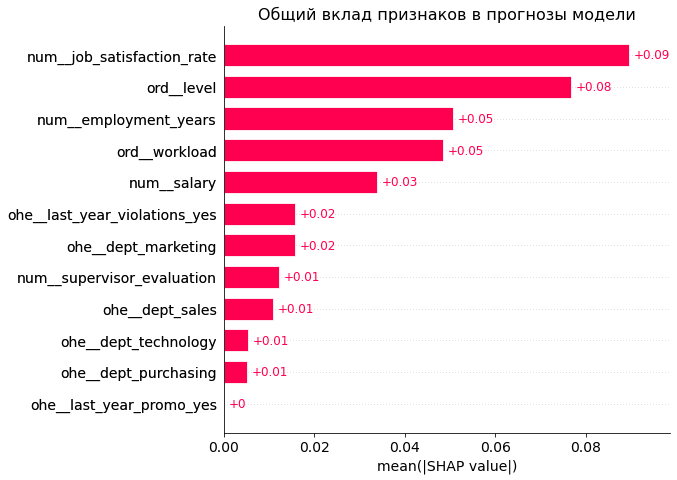

In [93]:
shap.plots.bar(shap_values[:,:,1], show=False, max_display=12)

fig, ax = plt.gcf(), plt.gca()

ax.tick_params(labelsize=14)
ax.set_xlabel('mean(|SHAP value|)', fontsize=14)
ax.set_title('Общий вклад признаков в прогнозы модели', fontsize=16)

plt.show()

Больше всего на результат работы модели влияют: **job_satisfaction_rate, level, employment_years**

### Промежуточные выводы

Задача 2 выполнена. Была построена модель, которая предсказывает, уволится сотрудник или нет, на основе данных, что предоставил заказчик.

**В ходе исследования мы составили портрет "уволившегося сотрудника":**

- Распределение по отделам почти равномерное, немного больше ушло из отдела sales.

- В 82% - уровень junior.

- Загрузка чаще всего low и medium.

- Стаж в компании от 1 до 3х лет.

- Повышения за последний год почти никто не получил.

- более 70% не нарушали трудовой договор ща последний год.

- В основм от руководителя получают оценку 3, чуть меньшее количество - 4.

- Средняя зааботная плата примерно 23000.


**Подготовка данных:**

**MinMaxScaler/StandartScaler** для стобцов **employment_years, salary, supervisor_evaluation, job_satisfaction_rate** - количественные признаки.

**OrdinalEncoder** для столбцов **level, workload** - порядковые признаки.

**OneHotEncoder** для столбцов **dept, last_year_promo, last_year_violations** - категориальные признаки


Лучшую искали среди четырех моделей: DecisionTreeClassifier, KNeighborsClassifier, SVC, LogisticRegression. Ею стала **SVC(C=6, probability=True, random_state=42).**

Значение метрики **roc-auc** на тестовой выборке **~0.93**, что является успехом.

Больше всего на результат работы модели влияют признаки  **job_satisfaction_rate, level, employment_years.**

## Общий вывод

**В ходе работы мы решили 2 задачи:**

**Первая** - построить модель, которая сможет предсказать уровень удовлетворённости сотрудника на основе данных заказчика. 

**Вторая** - остроить модель, которая сможет на основе данных заказчика предсказать то, что сотрудник уволится из компании.


**Для решения этих задач были проведены следующие этапы:**

1. **Загрузка и просмотр данных**.


2. **Предобработка данных**. Были найдены пропуски и дубликаты.


3. **Исследовательский анализ данных**. На данном этапе были построены графики и матрицы коррреляции.


4. **Подготовка данных**. Здесь написали пайплайны для заполнения пропусков, кодирования категориальных признаков и масштабирования количественных. 


5. **Обучение модели**. На данном этапе при помощи итогового пайплана мы перебирали модели, гиперпараметры, способы масштабирования, чтобы найти лучшую. 

**Проведя исследовательский и корреляционный анализ, выяснили:**

- В отделе продаж больше всего сотрудников.


- Сотрудников с уровнем junior и middle больше всего.


- У половины сотрудников средний уровень загруженности.


- Большая часть сотрудников работает в компании 1 - 2 года.


- Руководитель чаще всего выставляет сотрудникам оценки 3 и 4.


- 3% сотрудников получили повышение за последний год.


- ~ 14% нарушали трудовой договор за последний год.


- Зарплата большинства сотрудников от 12000 до 43000 рублей.


- Соотношение довольных и недовольных работой примерно равно.


- level имеет положительную корреляцию с salary(0.71) и employment_years(0.68). Workload положительно коррелирует с salary(0.79). job_satisfaction_rate сильно коррелирует с supervisor_evaluation(0.76). 


- quit имеет положительную корреляцию с признаками employment_years(0.61), salary(0.51) и job_satisfaction_rate(0.57).


- У оставшихся сотрудников уровень удовлетворенности в среднем 0.66, у уволившихся - 0.37.


**Составили портрет «уволившегося сотрудника:**

1. Распределение по отделам почти равномерное, немного больше ушло из отдела sales.
2. В 82% - уровень junior.
3. Загрузка чаще всего low и medium.
4. Стаж в компании от 1 до 3х лет.
5. Повышения за последний год почти никто не получил.
6. более 70% не нарушали трудовой договор ща последний год.
7. В основм от руководителя получают оценку 3, чуть меньшее количество - 4.
8. Средняя зааботная плата примерно 23000.

Для **первой задачи** лучшая модель **DecisionTreeRegressor(max_depth=23, min_samples_leaf=3, min_samples_split=8, random_state=42)**.
Значение метрики **SMAPE** на тестовой выборке составляет **13.35**.

Для **второй** - **SVC(C=6, probability=True, random_state=42)**. Значение метрики **roc-auc** на тестовой выборке **~0.93**.


Анализ признаков показал, что сотрудник будет вероятнее удовлетворен работой, если у него высокая оценка от руководителя. На увольнение сотрудников больше всего влияют: уровень удовлетворённости сотрудника работой, уровень занимаемой должности и стаж работы.

**Предложения для бизнеса для снижения оттока сотрудников:**

80% уволившихся сотрудников составляют новички - уровень junior и стаж в компании от 1 до 3х лет. Для удержания рекомендую больше уделять внимания, помогать освоиться, также поднять уровень загруженности (т.к. она для большинства - low и middle), поднять зарплатную плату (средняя зп составляет 23000). Либо нанимать более квалифицированных специалистов с высоким стажем и уровнем занимаемой должности.

Почти у 100% уволившихся сотрудников не было повышения за последний год. Думаю, стоит пересмотреть карьерный рост. Можно составить систему грейдирования.